In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os

In [85]:
def calibrate_camera(nx = 9, ny = 6):
    """
     This functions calibrate the camera with chess board method.
     
     1. Read all the images from camera_cal
     2. Convert to gray scale
     3. find the chess board corners
     4. append the points in image points
     5. calibrate the camera and return mtx and dist
    """
    
    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.
    
    # Prepare object point
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    # load all the images via glob
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for image_name in images:
        
        # read the image
        img = mpimg.imread(image_name)
        
        # Convert to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
        # if ret is true, add object points
        if ret == True:
            
            # add image points and object point.
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            print('unable to find the corners for image - ', image_name)
    
    # Calibrate the camera and return the mtx and dist
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist)


def undistort_image(img, mtx, dist):
    """
    This function takes in image, mtx and dist and undistort the image.
    """
    # undistort the image
    return cv2.undistort(img, mtx, dist, None, mtx)
    

unable to find the corners for image -  camera_cal\calibration1.jpg
unable to find the corners for image -  camera_cal\calibration4.jpg
unable to find the corners for image -  camera_cal\calibration5.jpg


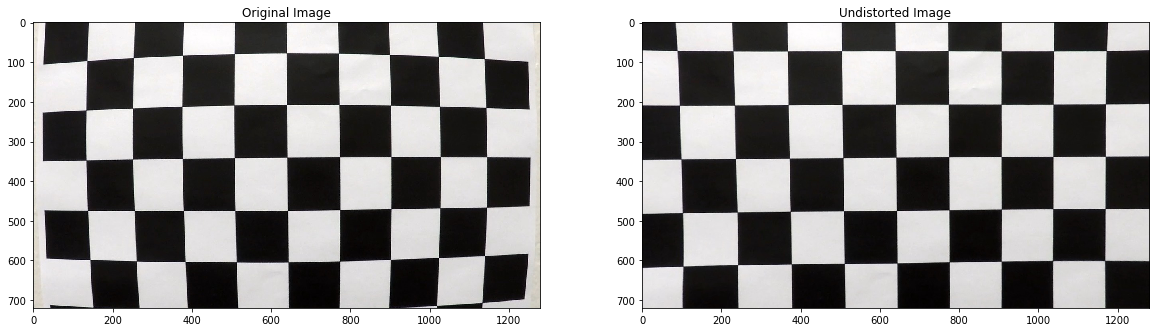

In [89]:
# Testing the undistorted image

# Calibrate camera
mtx, dist = calibrate_camera()

# Undistort the image
undistorted_img = undistort_image(image, mtx, dist)

# Test the output

img = mpimg.imread('camera_cal/calibration1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image')

plt.savefig('output_images/undistorted_chess_image.png')

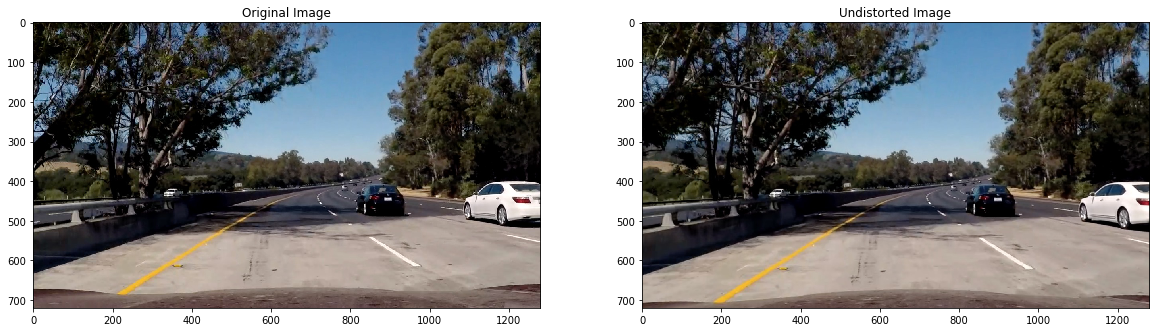

In [90]:
# Testing on the car image.
img = mpimg.imread('test_images/test5.jpg')

# Undistort the image. No need for calibration again.
dst =  undistort_image(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(dst)
ax2.set_title('Undistorted Image')

plt.savefig('output_images/undistorted_car_image.png')

In [91]:
def abs_sobel_thresh(img, orient='x', thresh =(0,255)):
    
    # Gray Scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # take the derivative in x or y given orient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # mask of 1's where the scaled gradient magnitude
    # is >= thresh_min and <= thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the binary image
    return grad_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    This function applies Sobel x and y,
    then compute the magnitude of the gradient
    then applies a threshold and return binary output
    """
    
    # Take the gradient of x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary mask
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return mag_binary


def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    This function defines the sobel x and y
    Then computes the direction of the gradient and apply a threshold
    """
    
    # Take the gradient of x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the gradient direction
    grad_dir = np.arctan2(abs_sobelx, abs_sobely)
    
    # Create a binary mask
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    
    # Return the binary image
    return dir_binary

def color_threshold(s_channel, thresh=(0, 255)):
    """
    This function returns a binary color threshold.
    """
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

In [92]:
def combined_color_pipeline(img, sobel_thresh=(20, 100), color_thresh=(170, 255)):
    """
    This function combines Sobel X and apply color thresholding
    and return combined binary
    """
    
    # HLS and color threshold
    hls = cv2.cvtColor(undistored_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Sobel X
    gradx = abs_sobel_thresh(undistored_image, orient='x', thresh=(20, 100))

    # Color Channel
    s_binary = color_threshold(s_channel, thresh=(170, 255))

    # Stack each channel
    color_binary = np.dstack((np.zeros_like(gradx), gradx, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (gradx == 1)] = 1
    
    return combined_binary

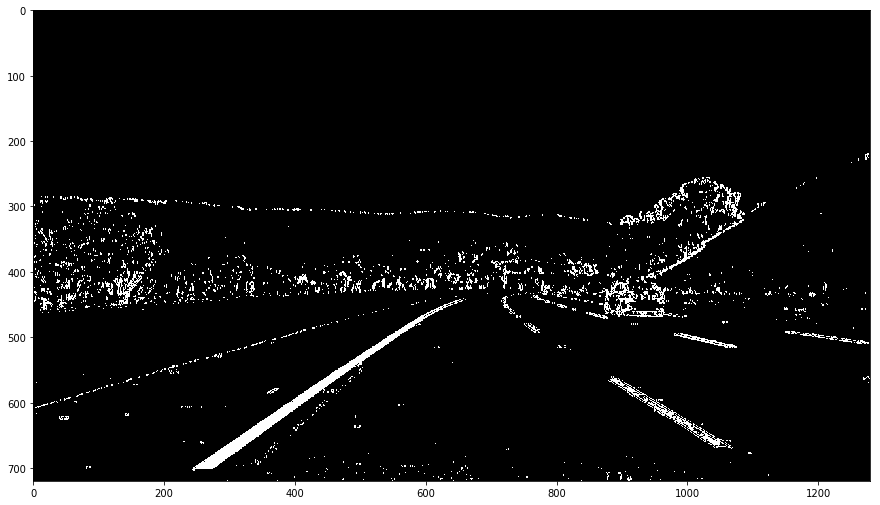

In [94]:
img = mpimg.imread('test_images/test3.jpg')
undistored_image = undistort_image(img, mtx, dist)

# usage of pipe line
combined = combined_color_pipeline(undistored_image)

fig = plt.gcf()
fig.set_size_inches(15, 20)
plt.imshow(combined, cmap='gray')

plt.savefig('output_images/sobelx_color_thresh_image.png')

In [95]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

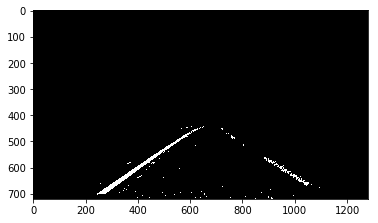

<Figure size 432x288 with 0 Axes>

In [97]:
width, height, channels = img.shape
vertices = np.array([[
                (50, width),
                (height/2 - 50,3*width/5),
                (height/2 + 50,3*width/5),
                (height-50,width),
            ]], dtype=np.int32)

# Region of interest
masked_image = region_of_interest(combined, vertices)
plt.imshow(masked_image, cmap='gray')
plt.show()

plt.savefig('output_images/color_thresh_region_image.png')

In [98]:
def image_wrapper(img):
    """
    This function calculates the perspective transform.
    """
    
    imshape = image.shape
    
    src_points = np.float32([
        (0 + 185, imshape[0]),
        (imshape[1]/2 - 55, 455),
        (imshape[1]/2 + 55, 455),
        (imshape[1] - 145, imshape[0])
    ])

    dest_points = np.float32([
        (0 + 325, imshape[0]),
        (0 + 325, 0),
        (imshape[1] - 325, 0),
        (imshape[1] - 325, imshape[0])])
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Calculate the perspective transform
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    
    # Wrap the image using open cv wrapPerspective
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

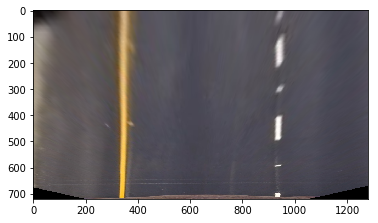

In [109]:
# Test the wraping on the straight line image

img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_image = undistort_image(img, mtx, dist)

wrapped_image = image_wrapper(undistorted_image)

plt.imshow(wrapped_image)

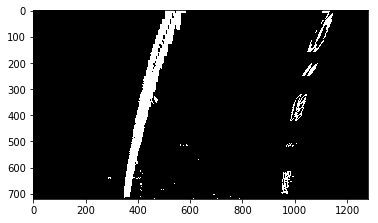

In [110]:
wrapped_image = image_wrapper(masked_image)
plt.imshow(wrapped_image, cmap='gray')

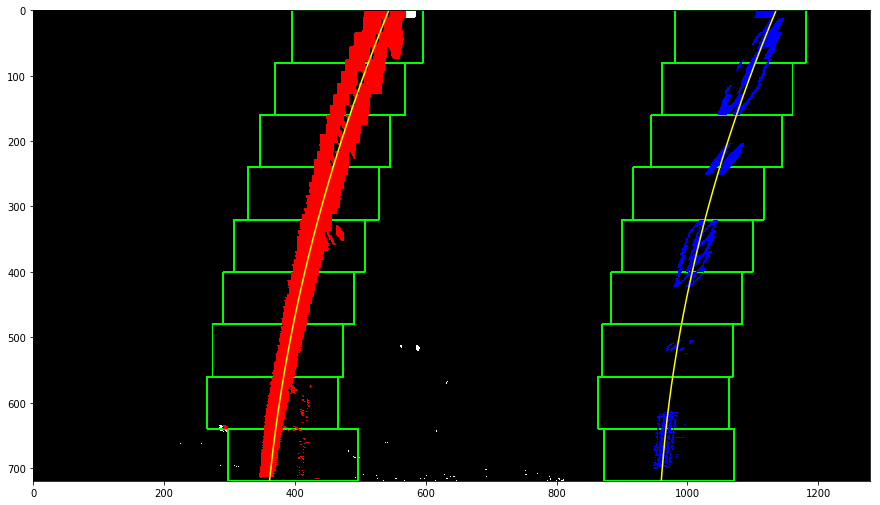

In [113]:
def find_lane_pixels(binary_warped):
    
    # Bottom half of the image
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]

    # Take the histogram
    histogram = np.sum(bottom_half, axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(wrapped_image)

fig = plt.gcf()
fig.set_size_inches(15, 20)
plt.imshow(out_img)

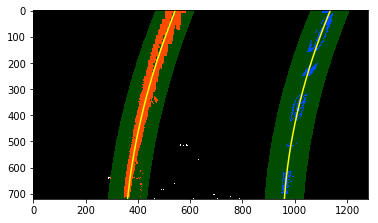

In [115]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# Finding the lines

def search_around_poly(binary_warped):
    
    margin = 75

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

result = search_around_poly(wrapped_image)

# View your output
plt.imshow(result)

In [120]:
# Measuring Curvature

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
avg_curverad = (left_curverad +  right_curverad) / 2
print('Left lane radius: %.2f m\nRight lane radius: %.2f m\nAvg. radius: %.2f m' % \
      (left_curverad, right_curverad, avg_curverad))

rad_str = 'Radius of Curvature = %dm' % np.round(avg_curverad)
print(rad_str)


Left lane radius: 820.50 m
Right lane radius: 682.92 m
Avg. radius: 751.71 m
Radius of Curvature = 752m


In [121]:
y_eval = np.max(ploty)
leftx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
rightx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
lane_center_px = (leftx + rightx) / 2

lane_center_offset_px = lane_center_px - (binary_warped.shape[1] / 2)
lane_center_offset_m = lane_center_offset_px * xm_per_pix
offset_str = 'Vehicle is %.2fm off center of lane' % lane_center_offset_m
print(offset_str)

Vehicle is 0.11m off center of lane


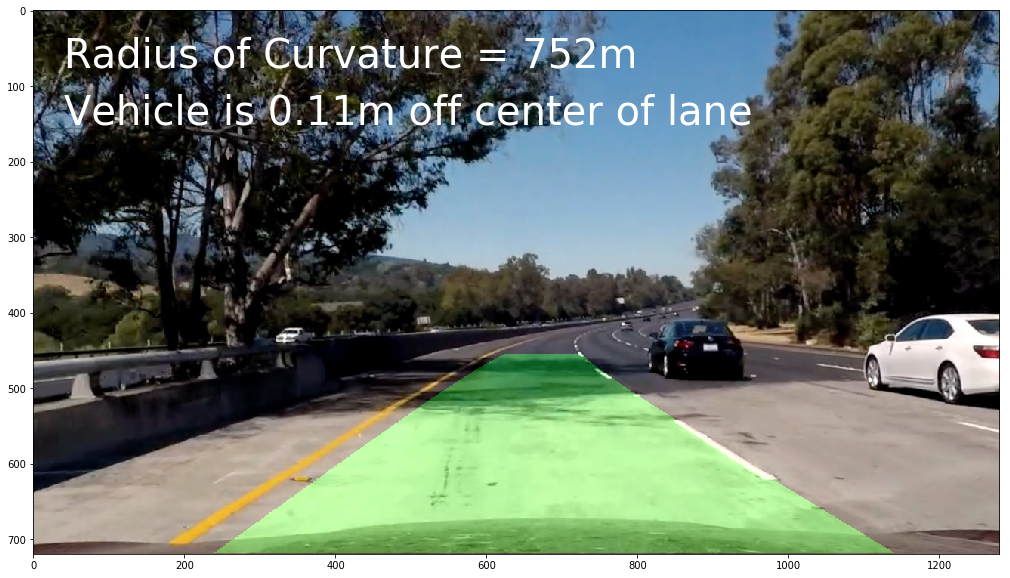

In [122]:
def unwarper(img):
    
    imshape = image.shape
    
    src_points = np.float32([
        (0 + 185, imshape[0]),
        (imshape[1]/2 - 55, 455),
        (imshape[1]/2 + 55, 455),
        (imshape[1] - 145, imshape[0])
    ])

    dest_points = np.float32([
        (0 + 325, imshape[0]),
        (0 + 325, 0),
        (imshape[1] - 325, 0),
        (imshape[1] - 325, imshape[0])])
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dest_points, src_points)
    dewarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return dewarped

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

original_image = cv2.cvtColor(cv2.imread('test_images/test5.jpg'), cv2.COLOR_BGR2RGB);
undist = cv2.undistort(original_image, mtx, dist, None, mtx);

warped = wrapped_image;

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0));

newwarp = unwarper(color_warp)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

f, ax = plt.subplots(1, figsize=(20, 10));
ax.imshow(result);
ax.text(40, 75, rad_str, color='w', fontsize=40);
ax.text(40, 150, offset_str, color='w', fontsize=40);
f.savefig('output_images/final_output_img.png');